In [1]:
%cd ../../..



/home/govind/gov_semproject/GridCellsCopy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.pyplot import cm
import h5py
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from scipy import integrate
from param import Param


In [3]:
params = Param()
lambda_0 = params["lambda0"]

In [ ]:
seed=67
np.random.seed(seed)
sim_dur_s=60
sim_dur_s_init = 8 #initial allothetic trajectory duration
allothetic_dur=sim_dur_s_init*1000
Env = Environment(
        params = {'dimensionality':'1D',
                'boundary_conditions':'periodic','scale':lambda_0/100})

#generate allothetic trajectory for 8s (fixed position)
Ag= Agent(Env,
        params = {'dt':0.000025,'speed_mean':0,'speed_std':0}) #0.000025 
Ag.pos=[0]
for i in tqdm(range(int((sim_dur_s_init/Ag.dt)+1))): 
        Ag.update()

#generate rest of the trajectory
Ag.speed_mean= 0.08
Ag.speed_std=0.00
sim_dur_s_traj = sim_dur_s-sim_dur_s_init
for i in tqdm(range(int((sim_dur_s_traj/Ag.dt)+1))): 
        Ag.update()

In [ ]:
t=np.array(Ag.history['t'])*1000 #s->ms
pos=np.array(Ag.history['pos'])*100 #m-->cm
vel=np.array(Ag.history['vel']).ravel()/10 #m/s --> cm/ms
traj_start_idx = int((sim_dur_s_init)/0.000025)
t=t/1000 #ms-->s
vel=vel*1000
vel[abs(vel)>10]=10 #pin the velocity to 10 since network saturates around 10 rad/s
pos_integrated=integrate.cumulative_trapezoid(vel,t)%(2*np.pi)
plt.style.use("analysis/config/paper.mplstyle")
plt.figure(figsize=(10,2))
plt.scatter(t[:-1],pos_integrated,s=0.5)
plt.show()

In [ ]:
#save trajectory
traj_id ="tmod2"
fname="input_data/trajectories/traj_{}.hdf5".format(traj_id)
with h5py.File(fname, 'w') as file:
    file.create_dataset("vel_rinb",  data=vel,compression='gzip')
    file.create_dataset("pos_rinb",data=pos_integrated,compression='gzip')
    file.create_dataset("t_rinb",data=t,compression='gzip')
    file.attrs.create("allothetic_dur",allothetic_dur)
    file.attrs.create("traj_dur",int(sim_dur_s))
    file.attrs.create("traj_params",(Ag.speed_mean,Ag.speed_std,Ag.speed_coherence_time,seed))

In [4]:

import matplotlib.cm as cm
import numpy as np
import sim_utils as s_utils
import analysis_utils as a_utils
from network_configs.instrumentations.trajectory1D import Trajectory1D
from scipy import stats
import h5py

In [5]:
def circular_error(var1,var2):

    """Calculate the circular error between two angles.

    Parameters:
        var1 (float or array-like): The first angle in radians.
        var2 (float or array-like): The second angle in radians.
    Returns:
        numpy.ndarray: The minimum absolute difference between the angles
    """
    circum = 2*np.pi
    return np.abs(np.min(np.vstack((np.abs(var1-var2),circum-np.abs(var1-var2))),axis=0))

In [10]:
def decode_func(sim_id, sim_num, n_trials=10, sim_dur = float(60000)):
    """
    Take in Sim ID, Number

    Return arrays of mean and standard deviation of decoded trajectories
    
    """

    params = s_utils.load_sim_params(sim_id=sim_id)["0"]
    traj = Trajectory1D(params, save_mem=False)
    dc_input = traj.intrnrn_dc
    decoded_positions = np.zeros((n_trials, int(params["sim_dur"] - traj.init_allothetic_dur)))

    file_path_stell = f"data/{sim_id}/stell_spks_{sim_id}.hdf5"

    with h5py.File(file_path_stell, "r") as f:
        print("Top-level groups:", list(f.keys()))
        for grp in f.keys():
            print(grp, "contains:", list(f[grp].keys()))

    for tr in range(n_trials):
        print("Trial Number ", tr)
        stell_spks, _ = s_utils.load_spikes(sim_id, sim_num)
        decoded_positions[tr, :] = a_utils.decode_pos(stell_spks, params, win_size=40, t_start=int(traj.init_allothetic_dur))
        sim_num += 1

    mean_decode_posns = stats.circmean(decoded_positions, axis=0)
    std_decode_posns = stats.circstd(decoded_positions, axis=0)

    return mean_decode_posns, std_decode_posns


def posn_vel_input(sim_id, sim_num, n_trials=10, sim_dur = float(60000)):
    params = s_utils.load_sim_params(sim_id=sim_id)["0"]
    traj = Trajectory1D(params, save_mem=False)
    t_ms = np.arange(traj.init_allothetic_dur,params["sim_dur"])
    t_ms_idx = (t_ms/0.025).astype('int')
    position_input = traj.pos_input[t_ms_idx]
    velocity_input = traj.vel_input[t_ms_idx]
    t_s= np.linspace(traj.init_allothetic_dur/1000,(params['sim_dur']/1000),int(params["sim_dur"]-traj.init_allothetic_dur))

    return position_input, velocity_input, t_s


In [17]:
def plot_mult_stddev(sim_id_list,sim_num=0,save=None):
    _,_,t_s=posn_vel_input(sim_id_list[0],sim_num)
    plt.figure(figsize=(22,10))
    for sim_id in sim_id_list:
        _,std = decode_func(sim_id,sim_num)
        plt.plot(t_s,std,label=f"{sim_id}")
    plt.legend()
    plt.show()
    if save:
        plt.savefig(f"{save}.png")
    return None

def plot_mult_error(sim_id_list,sim_num=0,save=None):
    pos_input,_,t_s=posn_vel_input(sim_id_list[0],sim_num)
    plt.figure(figsize=(22,10))
    for sim_id in sim_id_list:
        mean,_ = decode_func(sim_id,sim_num)
        error = circular_error(pos_input[:-1],mean[1:])
        plt.plot(t_s[1:],error,label=f"{sim_id}")
    plt.legend()
    plt.show()
    if save:
        plt.savefig(f"{save}.png")
    return None




        





#### Testing the effect of removing the intrinsic theta oscillations

Sim IDs : `THTA_3` : No forced oscillations + intrinsic theta amplitude intact
          `THTA_4` : No forced oscillations + no intrinsic theta amplitude

[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
Top-level groups: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0 contains: ['stell_spks']
1 contains: ['stell_spks']
2 contains: ['stell_spks']
3 contains: ['stell_spks']
4 contains: ['stell_spks']
5 contains: ['stell_spks']
6 contains: ['stell_spks']
7 contains: ['stell_spks']
8 contains: ['stell_spks']
9 contains: ['stell_spks']
Trial Number  0
Hallelujah
Stellate File Path :  data/THTA_3/stell_spks_THTA_3.hdf5
Interneuron File Path :  data/THTA_3/intrnrn_spks_THTA_3.hdf5
Trial Number  1
Hallelujah
Stellate File Path :  data/THTA_3/stell_spks_THTA_3.hdf5
Interneuron File Path :  data/THTA_3/intrnrn_spks_THTA_3.hdf5
Trial Number  2
Hallelujah
Stellate File Path :  data/THTA_3/stell_spks_THTA_3.hdf5
Interneuron File Path :  data/THTA_3/intrnrn_spks_THTA_3.hdf5
Trial Number  3
Hallelujah
St

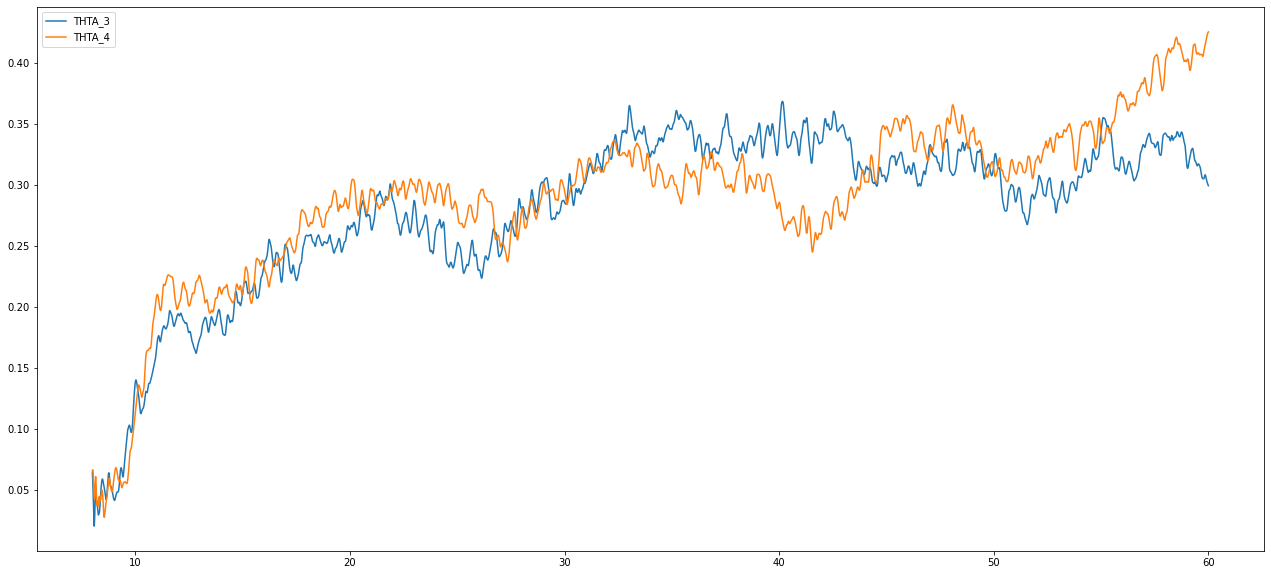

In [15]:
plot_mult_stddev(["THTA_3","THTA_4"])


[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
Top-level groups: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0 contains: ['stell_spks']
1 contains: ['stell_spks']
2 contains: ['stell_spks']
3 contains: ['stell_spks']
4 contains: ['stell_spks']
5 contains: ['stell_spks']
6 contains: ['stell_spks']
7 contains: ['stell_spks']
8 contains: ['stell_spks']
9 contains: ['stell_spks']
Trial Number  0
Hallelujah
Stellate File Path :  data/THTA_3/stell_spks_THTA_3.hdf5
Interneuron File Path :  data/THTA_3/intrnrn_spks_THTA_3.hdf5
Trial Number  1
Hallelujah
Stellate File Path :  data/THTA_3/stell_spks_THTA_3.hdf5
Interneuron File Path :  data/THTA_3/intrnrn_spks_THTA_3.hdf5
Trial Number  2
Hallelujah
Stellate File Path :  data/THTA_3/stell_spks_THTA_3.hdf5
Interneuron File Path :  data/THTA_3/intrnrn_spks_THTA_3.hdf5
Trial Number  3
Hallelujah
St

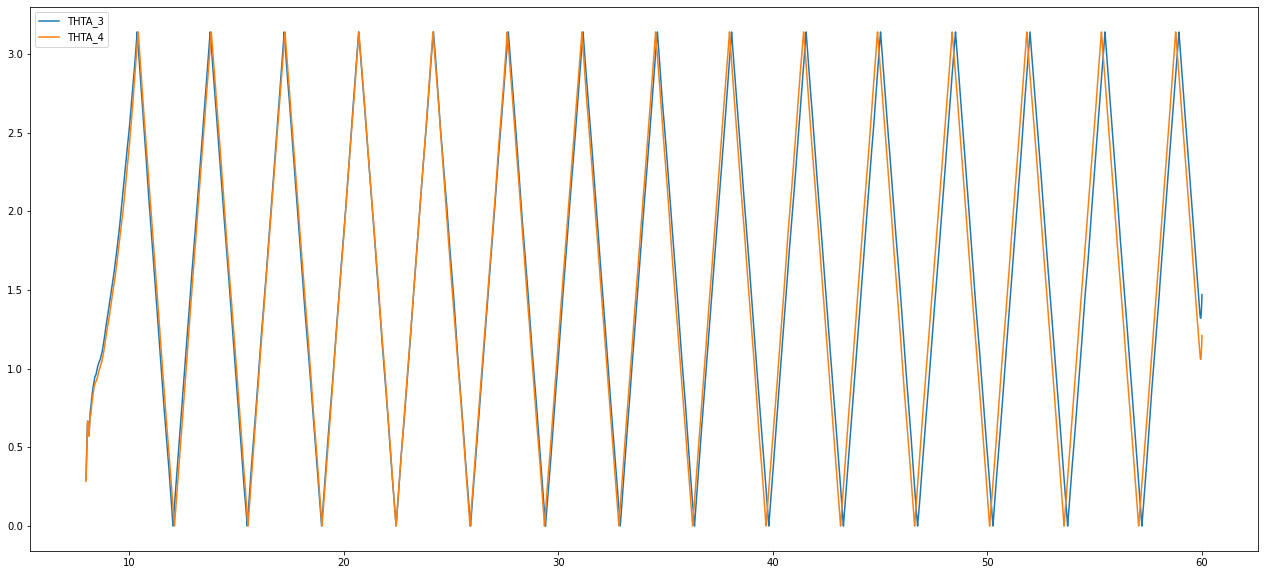

In [18]:
plot_mult_error(["THTA_3","THTA_4"])

#### Testing effect of different amplitudes of theta oscillations

`THTA_1`, `THTA_11`, `THTA_12` - Constant Oscillations
`THTA_2`, `THTA_21`, `THTA_22` - Modulated Oscillations


[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
Top-level groups: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0 contains: ['stell_spks']
1 contains: ['stell_spks']
2 contains: ['stell_spks']
3 contains: ['stell_spks']
4 contains: ['stell_spks']
5 contains: ['stell_spks']
6 contains: ['stell_spks']
7 contains: ['stell_spks']
8 contains: ['stell_spks']
9 contains: ['stell_spks']
Trial Number  0
Hallelujah
Stellate File Path :  data/THTA_1/stell_spks_THTA_1.hdf5
Interneuron File Path :  data/THTA_1/intrnrn_spks_THTA_1.hdf5
Trial Number  1
Hallelujah
Stellate File Path :  data/THTA_1/stell_spks_THTA_1.hdf5
Interneuron File Path :  data/THTA_1/intrnrn_spks_THTA_1.hdf5
Trial Number  2
Hallelujah
Stellate File Path :  data/THTA_1/stell_spks_THTA_1.hdf5
Interneuron File Path :  data/THTA_1/intrnrn_spks_THTA_1.hdf5
Trial Number  3
Hallelujah
St

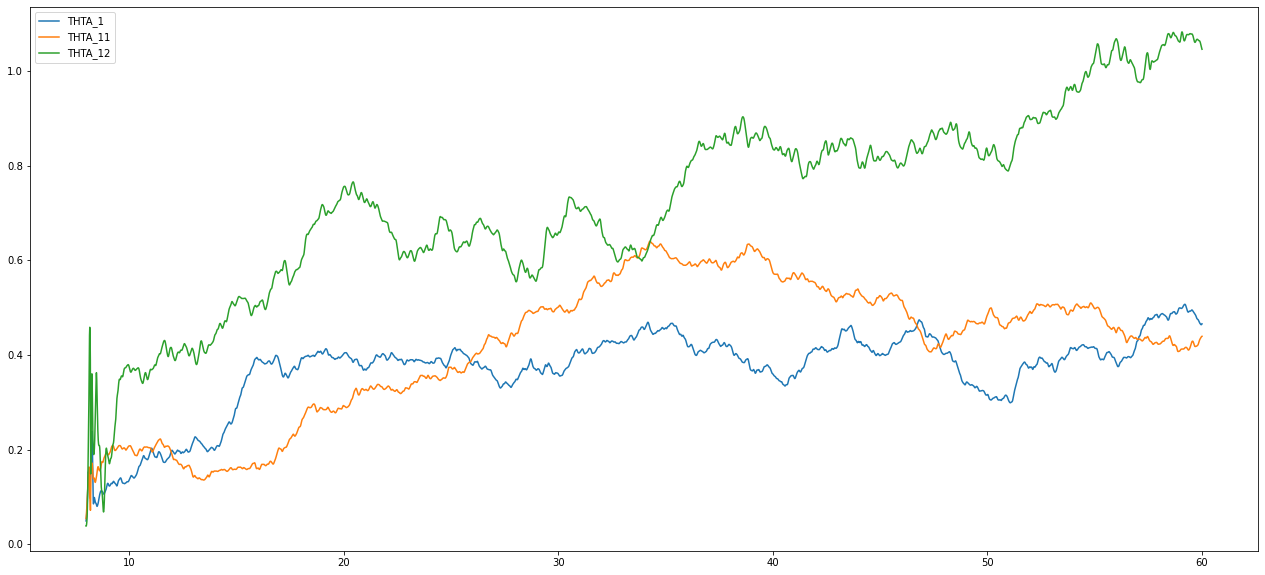

In [19]:
plot_mult_stddev(["THTA_1","THTA_11","THTA_12"])

[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
[2.49986607e-11 4.99964287e-11 7.49933038e-11 ... 1.99285575e+00
 1.99305575e+00 1.99325575e+00]
Top-level groups: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0 contains: ['stell_spks']
1 contains: ['stell_spks']
2 contains: ['stell_spks']
3 contains: ['stell_spks']
4 contains: ['stell_spks']
5 contains: ['stell_spks']
6 contains: ['stell_spks']
7 contains: ['stell_spks']
8 contains: ['stell_spks']
9 contains: ['stell_spks']
Trial Number  0
Hallelujah
Stellate File Path :  data/THTA_2/stell_spks_THTA_2.hdf5
Interneuron File Path :  data/THTA_2/intrnrn_spks_THTA_2.hdf5
Trial Number  1
Hallelujah
Stellate File Path :  data/THTA_2/stell_spks_THTA_2.hdf5
Interneuron File Path :  data/THTA_2/intrnrn_spks_THTA_2.hdf5
Trial Number  2
Hallelujah
Stellate File Path :  data/THTA_2/stell_spks_THTA_2.hdf5
Interneuron File Path :  data/THTA_2/intrnrn_spks_THTA_2.hdf5
Trial Number  3
Hallelujah
St

FileNotFoundError: Cannot locate data for sim ID: THTA_21

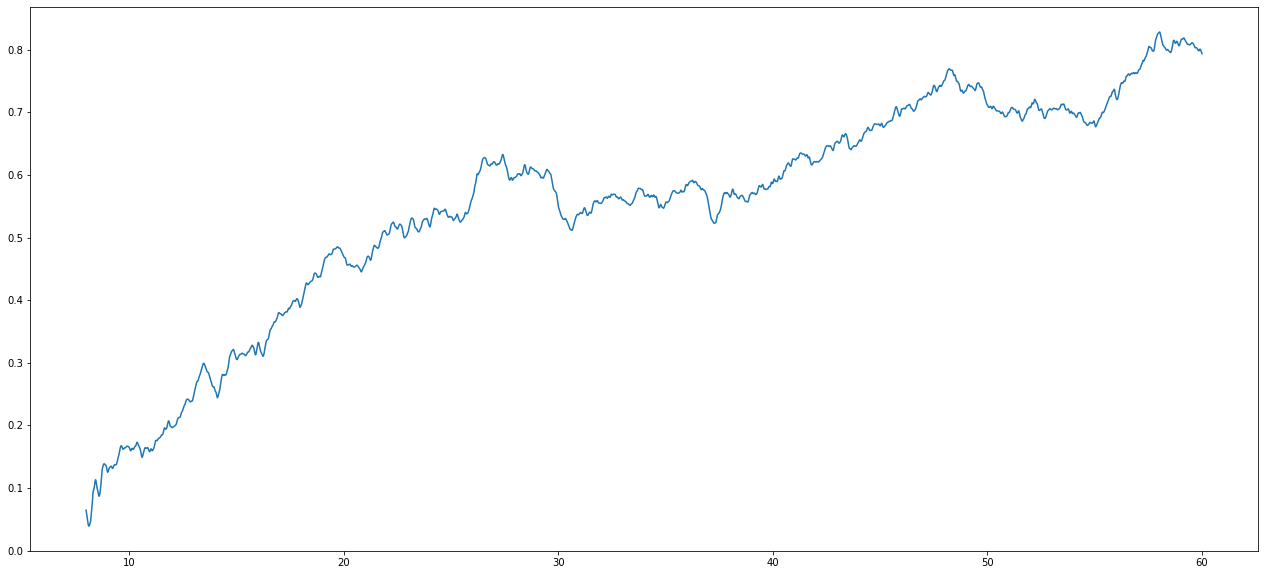

In [20]:
plot_mult_stddev(["THTA_2","THTA_21","THTA_22"])